### In-vitro data

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pathlib import Path
import spikeinterface.full as si

%matplotlib widget

In [18]:
#base_data_folder = Path("/home/samuel/DataSpikeSorting/data_cns_lyon_2025/")
#working_folder = Path("/home/samuel/DataSpikeSorting/data_cns_lyon_2025/results")

base_data_folder = Path("/home/pierre/data/gdr/bordeaux/raw_datas/")
working_folder = Path("/home/pierre/data/gdr/bordeaux/results")

recording_stem = "human_ngn2_100K_c_55D"
recording_name = f"{recording_stem}.brw"

results_folder = working_folder / recording_stem

In [19]:
recording = si.read_biocam(base_data_folder / recording_name)

In [20]:
recording = recording.remove_channels(recording.channel_ids[:1])
recording

ChannelSliceRecording: 4095 channels - 10103.075195 Hz - 1 segments - 1,211,049 samples 
                       119.87s (2.00 minutes) - uint16 dtype - 9.24 GiB

In [21]:
recording = si.unsigned_to_signed(recording, bit_depth=12)

In [22]:
recording

UnsignedToSignedRecording: 4095 channels - 10103.075195 Hz - 1 segments - 1,211,049 samples 
                           119.87s (2.00 minutes) - int16 dtype - 9.24 GiB

In [23]:
recording_processed = si.bandpass_filter(recording, freq_max=5000, dtype='float32')
recording_processed = si.common_reference(recording_processed)

In [24]:
recording_processed

CommonReferenceRecording: 4095 channels - 10103.075195 Hz - 1 segments - 1,211,049 samples 
                          119.87s (2.00 minutes) - float32 dtype - 18.47 GiB

In [25]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

In [26]:
si.set_global_job_kwargs(n_jobs=-1, chunk_duration="100ms")

In [ ]:
peaks = detect_peaks(
    recording_processed,
    method="locally_exclusive",
    method_kwargs=dict(
        detect_threshold=6.,
        exclude_sweep_ms=0.1,
        radius_um=75.)
)

In [29]:
import matplotlib.pyplot as plt

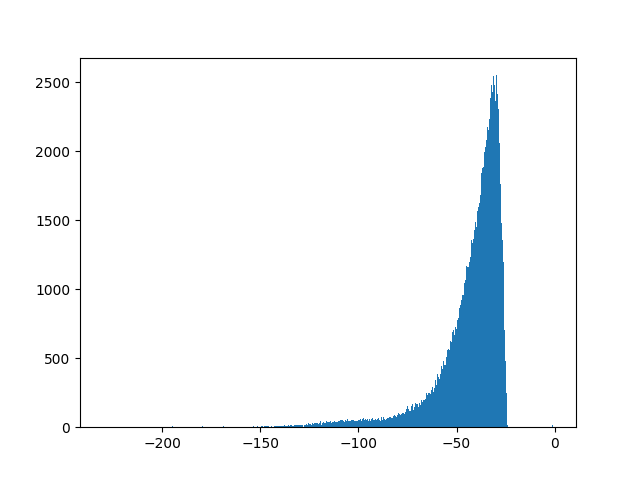

In [30]:
fig, ax = plt.subplots()
a = ax.hist(peaks['amplitude'], bins=500)

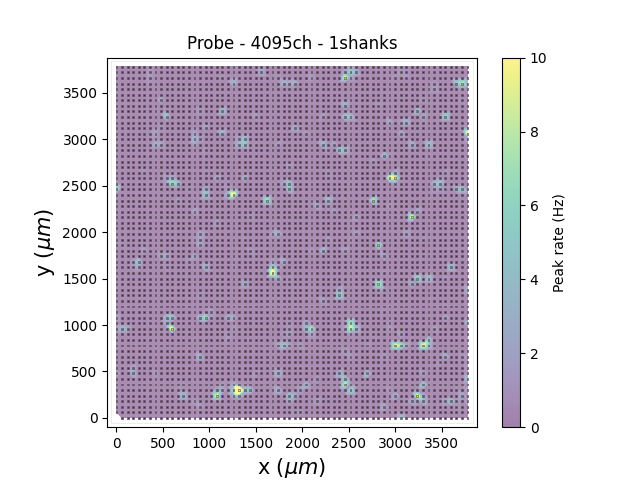

In [32]:
si.plot_peak_activity(recording, peaks, color_range=[0, 10])

In [19]:
sorting =si.NumpySorting.from_peaks(peaks, recording.sampling_frequency, recording.channel_ids)
sorting

NumpySorting: 4095 units - 1 segments - 10.1kHz

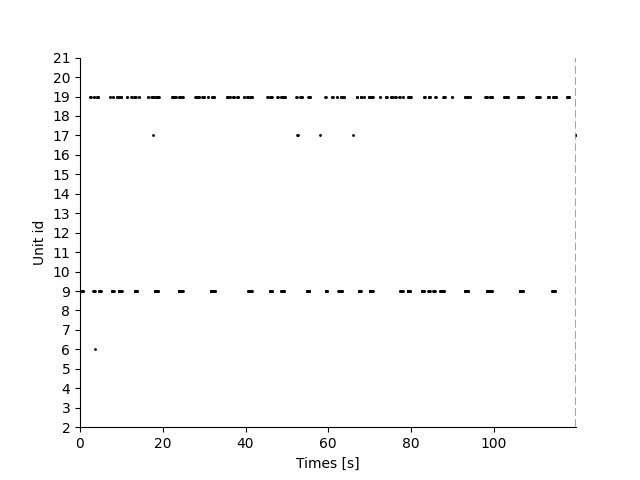

In [20]:
si.plot_rasters(sorting, unit_ids=sorting.unit_ids[:20])

In [12]:
sorting_SC2 = si.run_sorter(sorter_name="spykingcircus2", recording=recording_processed, 
                           folder=working_folder / recording_name / "sorter_SC2",
                           verbose=True, remove_existing_folder=True, apply_preprocessing=False, apply_motion_correction=False)

Skipping preprocessing (whitening only)


noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/src/spikeinterface/sortingcomponents/tools.py:405: UserWarning: Recording too large to be preloaded in RAM...
  warnings.warn("Recording too large to be preloaded in RAM...")


get protoype waveforms (workers: 20 processes):   0%|          | 0/1200 [00:00<?, ?it/s]

detect peaks (matched_filtering) 
engine=process - n_jobs=20 - samples_per_chunk=1,010 - chunk_memory=15.78 MiB - total_memory=315.55 MiB - chunk_duration=0.10s (99.97 ms)


detect peaks (matched_filtering) (workers: 20 processes):   0%|          | 0/1200 [00:00<?, ?it/s]

Kept 284522 peaks for clustering


Fit peaks svd (workers: 20 processes):   0%|          | 0/1200 [00:00<?, ?it/s]

Transform peaks svd (workers: 20 processes):   0%|          | 0/1200 [00:00<?, ?it/s]

split_clusters with local_feature_clustering:   0%|          | 0/3250 [00:00<?, ?it/s]

Kept 3264 clean clusters
find spikes (circus-omp) 
engine=process - n_jobs=20 - samples_per_chunk=1,010 - chunk_memory=15.78 MiB - total_memory=315.55 MiB - chunk_duration=0.10s (99.97 ms)


find spikes (circus-omp) (workers: 20 processes):   0%|          | 0/1200 [00:00<?, ?it/s]

Found 556676 spikes
Kept 3256 units after final merging
spykingcircus2 run time 1792.28s


In [ ]:
analyzer = si.create_sorting_analyzer(sorting_SC2, recording_processed)
analyzer.compute({
    "random_spikes" : {},
    "templates": {},
    "waveforms": {},
    "noise_levels": {},
    "correlograms": {},
    "noise_levels": {},
    "spike_amplitudes": {},
    "spike_locations": {},
    "template_metrics": {},
    "unit_locations": {},
    "template_similarity": {},
    "quality_metrics": {},
})

In [22]:
from spikeinterface_gui import run_mainwindow
run_mainwindow(
    analyzer,
    with_traces=False,
    mode="desktop"
)

qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass
qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass
qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass
qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass
qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass
qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass
qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member fu

<spikeinterface_gui.backend_qt.QtMainWindow(0x479ab7d0) at 0x74ea6c687ec0>

In [18]:
sorting_HS = si.run_sorter(sorter_name="herdingspikes", recording=recording_processed, 
                           folder=working_folder / recording_name / "sorter_HS",
                           verbose=True, remove_existing_folder=True)

Exception: The sorter herdingspikes is not installed. Please install it with:

To use HerdingSpikes run:

       >>> pip install herdingspikes
    More information on HerdingSpikes at:
      * https://github.com/mhhennig/hs2
    

In [27]:
import numpy as np

In [31]:
active_chan, speak_count = np.unique(peaks['channel_index'],return_counts=True)

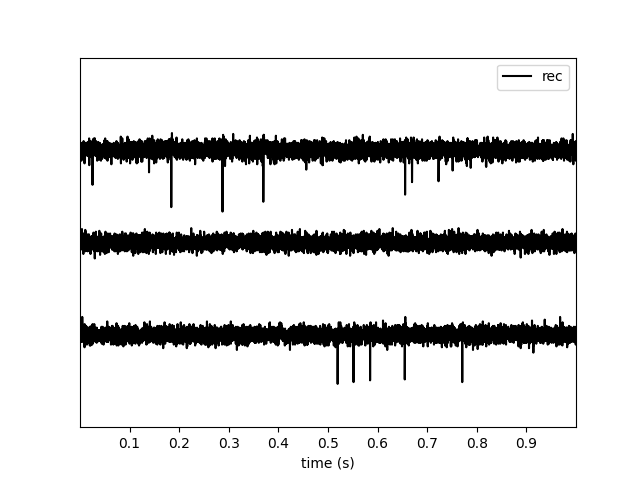

In [36]:
si.plot_traces(recording, channel_ids=va_chan_ids[1:4])

In [ ]:
sorting_HS

In [ ]:
analyzer = si.create_sorting_analyzer(sorting_HS, recording_processed)
extension_list = ["random_spikes", "templates", "unit_locations", "correlograms", "template_similarity", "spike_amplitudes"]
analyzer.compute(extension_list)

In [ ]:
si.plot_unit_templates(analyzer, backend="ipywidgets")

In [ ]:
si.plot_rasters(analyzer)

In [ ]:
potential_merges = si.compute_merge_unit_groups(analyzer, preset="x_contaminations")

In [ ]:
print(len(potential_merges))

In [ ]:
si.plot_potential_merges(analyzer, potential_merges, backend="ipywidgets")